**Final Individual Assignment** 
**SMM768-GeorgiosKalfas**

In [ ]:
# ---+ loading libraries
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.metrics import sparse_categorical_crossentropy
from tensorflow.data import Dataset, TFRecordDataset
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from sklearn.metrics import confusion_matrix

In [ ]:
# ---+ importing the files
with open ('time_series_1.pickle', 'rb') as handle:
  time_series_1 = pickle.load(handle)
with open ('time_series_2.pickle', 'rb') as handle:
  time_series_2 = pickle.load(handle)
with open ('y.pickle', 'rb') as handle:
  y = pickle.load(handle)

In [ ]:
# ---+ looking into the time series
print(time_series_1.shape)
print(type(time_series_1))
print(time_series_2.shape)
print(type(time_series_2))
print(y.shape)
print(type(y))

(4000, 5000)
<class 'numpy.ndarray'>
(4000, 5000)
<class 'numpy.ndarray'>
(4000,)
<class 'numpy.ndarray'>


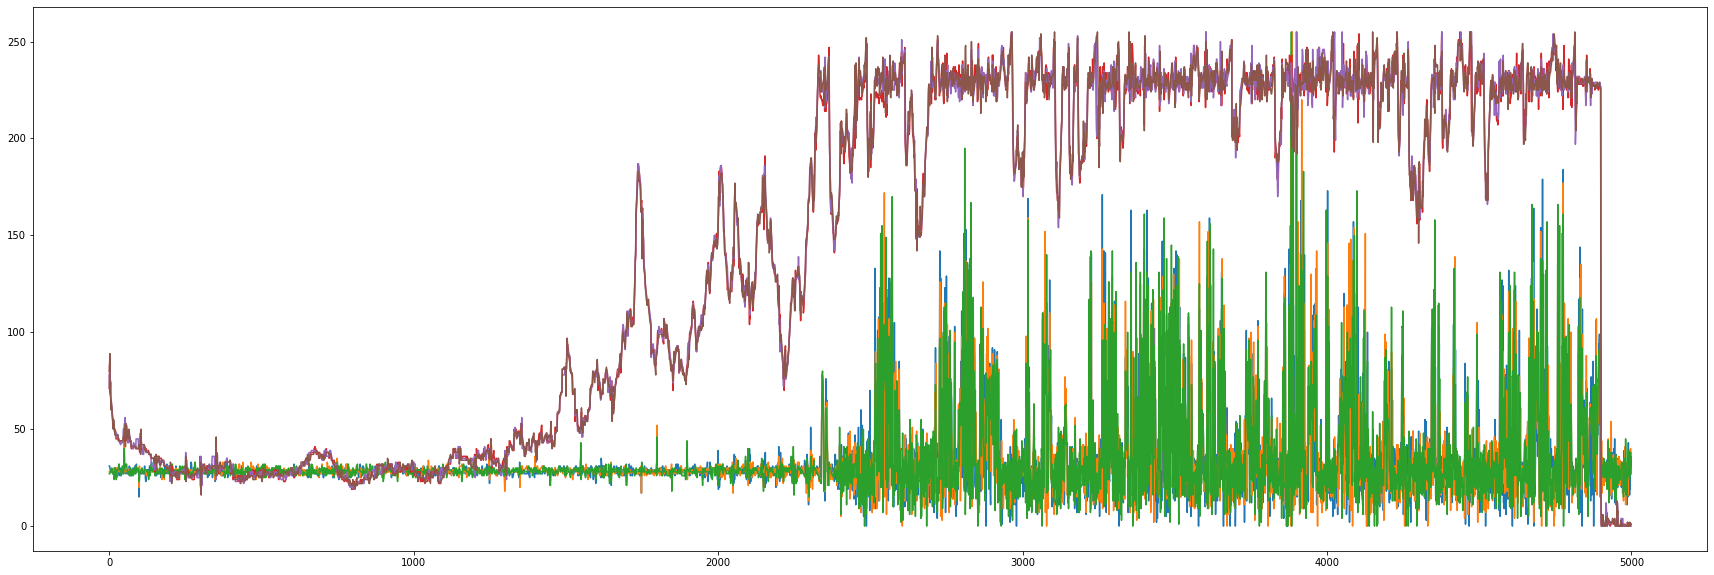

In [41]:
# ---+ visualising the time series 1
plt.figure(figsize=(30,10)) # ---+ adjusting the size of the figure
plt.plot(time_series_1[1,:])
plt.plot(time_series_1[2,:])
plt.plot(time_series_1[3,:])

# ---+ time series 2
plt.plot(time_series_2[1,:])
plt.plot(time_series_2[2,:])
plt.plot(time_series_2[3,:])

In [ ]:
# ---+ combining the time series
final = np.dstack((time_series_1, time_series_2))
print(final.shape)
print(type(final))

(4000, 5000, 2)
<class 'numpy.ndarray'>


In [ ]:
# ---+ reshaping y into the shape of the time_series
y_q1 = y.reshape(4000,1)
print(y_q1.shape)
print(type(y_q1))

(4000, 1)
<class 'numpy.ndarray'>


### **Making sure validation and test datasets consist of 15% of the observation each.**

In [ ]:
# ---+ creating training and test split
np.random.seed(132)
seq_steps = 5000

X_train, y_q1_train = final[:2800, :seq_steps], y_q1[:2800,]
X_valid, y_q1_valid = final[2800:3400, :seq_steps], y_q1[2800:3400,]
X_test, y_q1_test = final[3400:, :seq_steps], y_q1[3400:,]

print(X_train.shape)
print(y_q1_train.shape)
print(X_valid.shape)

(2800, 5000, 2)
(2800, 1)
(600, 5000, 2)


## **Question 1.**

Create a recurrent neural network in TensorFlow to predict the operating mode of a wind turbine based on the two time series from the sensors. Before any implementation, carefully consider what type of approach (sequence-to-vector, sequence-to-sequence, or encoder-decoder) is most sensible here and how you need to manipulate the data, given that you have two different time series for each observation.
 
Then, make sure that you try out the different layers and elements discussed in class, such as SimpleRNN, LSTM and Conv1D - while a certain amount of trial and error will be necessary, it is recommended that you tune your network systematically. Make sure to record your final validation set accuracy. 

## Function to train the data

In [ ]:
# ---+ creating the function to train our data (will be used for the rest different models)

def train_plot(model, learning_rate = 0.001, epochs = 15):
    tf.keras.backend.clear_session()
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=Adam(learning_rate = learning_rate), metrics=['Accuracy'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(X_train, y_q1_train, epochs=epochs,
                        validation_data=(X_valid, y_q1_valid),
                   callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    plt.show()
    
    return model, log

#### For the purpose of this analysis the type of approach we will use is sequence-to-vector.
#### Sequence to vector predicts the next value in the sequence and gives as an output the predicted value.

#### A recurrent neural network is a class of artificial neural networks where connections between nodes from a directed or undirected graph are used to represent the sequence of events.
#### A RNN layer uses a for loop to iterate over the timesteps of a sequence, while maintaining an internal state that is updated at each timestep based on the previous timestep’s state.
#### RNNs are a powerful and robust type of neural network that can be used for many tasks, including language modeling, speech recognition, and image captioning. 
#### They belong to the most promising algorithms in use because it is the only one with internal memory.

### **Training with a simple RNN model**

#### A simple RNN model, is  a fully-connected RNN where the output form the previous timestep is used as input to the next timestep.
#### For the purposes of this model we will use as input 20 units, and the activation function for our last layer will be "Softmax".

In [ ]:
# ---+ cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

In [ ]:
# ---+ creating the model
model_simple_rnn = Sequential([
    SimpleRNN(20, return_sequences = False, input_shape=[None, 2]),
    Dense(4, activation = "softmax")
])

model_simple_rnn.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20)                460       
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 544
Trainable params: 544
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
88/88 [==============================] - 103s 1s/step - loss: 1.3994 - Accuracy: 0.2761 - val_loss: 1.3609 - val_Accuracy: 0.3600
Epoch 2/15
88/88 [==============================] - 100s 1s/step - loss: 1.3449 - Accuracy: 0.3511 - val_loss: 1.3488 - val_Accuracy: 0.3833
Epoch 3/15
88/88 [==============================] - 99s 1s/step - loss: 1.3302 - Accuracy: 0.3450 - val_loss: 1.3357 - val_Accuracy: 0.3450
Epoch 4/15
88/88 [==============================] - 99s 1s/step - loss: 1.3180 - Accuracy: 0.3657 - val_loss: 1.3300 - val_Accuracy: 0.3583
Epoch 5/15
88/88 [==============================] - 109s 1s/step - loss: 1.3058 - Accuracy: 0.3739 - val_loss: 1.3226 - val_Accuracy: 0.3850
Epoch 6/15
88/88 [==============================] - 99s 1s/step - loss: 1.2970 - Accuracy: 0.3761 - val_loss: 1.3313 - val_Accuracy: 0.3517
Epoch 7/15
88/88 [==============================] - 102s 1s/step - loss: 1.2920 - Accuracy: 0.3950 - val_loss: 1.3117 - val_Accuracy: 0.4067
Epoch 8/15
88/88

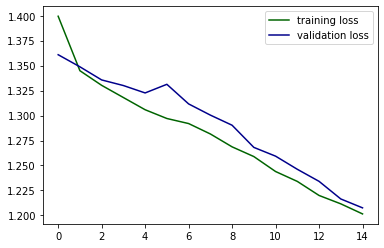

(<keras.engine.sequential.Sequential at 0x7ff381b2d650>,
 <keras.callbacks.History at 0x7ff37d85dfd0>)

In [ ]:
# ---+ training the model and plotting training and validation loss 
train_plot(model_simple_rnn) 

In [ ]:
# ---+ evaluating the model
score, acc= model_simple_rnn.evaluate(X_valid, y_q1_valid)

print("Validation score:", score)
print("validation accuracy:", acc)

19/19 [==============================] - 4s 195ms/step - loss: 1.2076 - Accuracy: 0.4517
Validation score: 1.207587480545044
validation accuracy: 0.4516666531562805


### **Training the data with a deeper RNN**

#### A deeper RNN model, is a fully-connected RNN where the output form the previous timestep is used as input to the next timestep. In this case we have multiple layers of recurrent nodes,
#### and we need to consider what to pass on between layers. Hence, we need to "set_sequences=True" in a recurrent layer, so all outputs will pass to the next layer.
#### For the purposes of this model we will use as input 20 units for the 2 first layers and the first one will have the return_sequences=True, and the activation function for our last layer will be "Softmax".

In [ ]:
# ---+ cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

In [ ]:
# ---+ building the deeper rnn model
model_deeper_rnn = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 2]),
    SimpleRNN(20), # ---+ 20 units each layers, Dense last layer for prediction, sequence elements are of dimension 1
    Dense(10, activation = "softmax") # ---+ sequence = True means that the output is actually a sequence (alternative is the final output of the sequence)
]) # ---+ at the end we dont care about the middle outputs just on the final one thats why sequence at the end True

model_deeper_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          460       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
Total params: 1,490
Trainable params: 1,490
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
88/88 [==============================] - 405s 5s/step - loss: 1.7745 - Accuracy: 0.2407 - val_loss: 1.4862 - val_Accuracy: 0.2700
Epoch 2/15
88/88 [==============================] - 415s 5s/step - loss: 1.4300 - Accuracy: 0.2768 - val_loss: 1.4027 - val_Accuracy: 0.3183
Epoch 3/15
88/88 [==============================] - 433s 5s/step - loss: 1.3709 - Accuracy: 0.3300 - val_loss: 1.3555 - val_Accuracy: 0.3600
Epoch 4/15
88/88 [==============================] - 408s 5s/step - loss: 1.3273 - Accuracy: 0.3911 - val_loss: 1.3226 - val_Accuracy: 0.4100
Epoch 5/15
88/88 [==============================] - 407s 5s/step - loss: 1.2922 - Accuracy: 0.4257 - val_loss: 1.2907 - val_Accuracy: 0.4150
Epoch 6/15
88/88 [==============================] - 407s 5s/step - loss: 1.2661 - Accuracy: 0.4393 - val_loss: 1.2808 - val_Accuracy: 0.4233
Epoch 7/15
88/88 [==============================] - 406s 5s/step - loss: 1.2485 - Accuracy: 0.4489 - val_loss: 1.2512 - val_Accuracy: 0.4300
Epoch 8/15
88

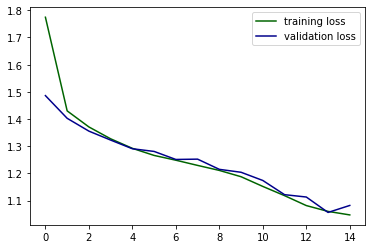

(<keras.engine.sequential.Sequential at 0x7ff37d777290>,
 <keras.callbacks.History at 0x7ff37d69e210>)

In [ ]:
# ---+ training and getting visualisations of the deeper RNN
train_plot(model_deeper_rnn)

In [ ]:
# ---+ evaluating the model
score, acc= model_deeper_rnn.evaluate(X_valid, y_q1_valid)

print("Validation score:", score)
print("validation accuracy:", acc)

19/19 [==============================] - 8s 398ms/step - loss: 1.0821 - Accuracy: 0.4950
Validation score: 1.0820729732513428
validation accuracy: 0.4950000047683716


### Training the data with LSTMs

#### A LSTM model, is a fully-connected RNN where the output form the previous timestep is used as input to the next timestep.
#### These models are an aritficial, advanced RNN architecture used in the field of deep learning. LSTMs have feedback connections.
#### LSTM allows information to persist, and it is capable of handling the vanishing gradient problem faced by RNN. LSTMs are designed to avodi long-term dependency problems.

In [ ]:
# ---+ cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

#### For this model we will use 2 LSTM layers as input, and a Dense layer with an activation fucntion of "softmax" as output.

In [ ]:
# ---+ building the LSTM model
model_lstm = Sequential([
    LSTM(20, return_sequences=True, input_shape=[None, 2]),
    LSTM(20),
    Dense(4, activation = "softmax")
])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1840      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 5,204
Trainable params: 5,204
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
88/88 [==============================] - 527s 6s/step - loss: 1.3841 - Accuracy: 0.2586 - val_loss: 1.3783 - val_Accuracy: 0.3533
Epoch 2/15
88/88 [==============================] - 524s 6s/step - loss: 1.3603 - Accuracy: 0.3346 - val_loss: 1.3336 - val_Accuracy: 0.3800
Epoch 3/15
88/88 [==============================] - 527s 6s/step - loss: 1.2930 - Accuracy: 0.4004 - val_loss: 1.2741 - val_Accuracy: 0.4200
Epoch 4/15
88/88 [==============================] - 531s 6s/step - loss: 1.2330 - Accuracy: 0.4393 - val_loss: 1.1907 - val_Accuracy: 0.4450
Epoch 5/15
88/88 [==============================] - 534s 6s/step - loss: 1.1586 - Accuracy: 0.4711 - val_loss: 1.1448 - val_Accuracy: 0.4817
Epoch 6/15
88/88 [==============================] - 539s 6s/step - loss: 1.1156 - Accuracy: 0.4986 - val_loss: 1.1276 - val_Accuracy: 0.4750
Epoch 7/15
88/88 [==============================] - 537s 6s/step - loss: 1.0918 - Accuracy: 0.5075 - val_loss: 1.0546 - val_Accuracy: 0.5283
Epoch 8/15
88

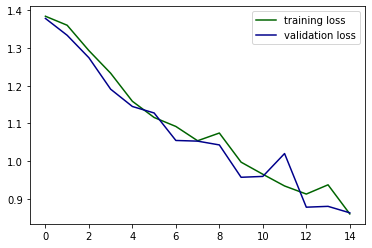

(<keras.engine.sequential.Sequential at 0x7ff37d777350>,
 <keras.callbacks.History at 0x7ff37d0ce750>)

In [ ]:
# ---+ training and getting visualisations of the LSTM
train_plot(model_lstm)

In [ ]:
# ---+ evaluating the model
score, acc= model_lstm.evaluate(X_valid, y_q1_valid)

print("Validation score:", score)
print("validation accuracy:", acc)

19/19 [==============================] - 11s 599ms/step - loss: 0.8627 - Accuracy: 0.6233
Validation score: 0.8627228736877441
validation accuracy: 0.6233333349227905


### **Training the data with GRUs**
#### and 1 convolutional layer

#### As the LSTMs the GRU give the solution for vanishing gradients, and they are capable of handling long-term dependency problems. They make use of memory cell to store the activation value of previous words 
#### in the long sequences.The so called gates(neural networks) are used to control the memory cell as long as the flow of information in the network. Gates are able to learn which inputs in the sequence are important
#### and store the information in the memory cell. Subsequently, they pass the information in long sequences and ues them to make predictions.

In [ ]:
# ---+ cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

In [ ]:
# ---+ building the GRU model
model_GRU = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 2]),
    GRU(20, return_sequences=True),
    GRU(20),
    Dense(4, activation = "softmax")
])
model_GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          180       
                                                                 
 gru (GRU)                   (None, None, 20)          2520      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 5,304
Trainable params: 5,304
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
88/88 [==============================] - 282s 3s/step - loss: 1.3021 - Accuracy: 0.3964 - val_loss: 1.2264 - val_Accuracy: 0.4517
Epoch 2/15
88/88 [==============================] - 281s 3s/step - loss: 1.1593 - Accuracy: 0.4904 - val_loss: 1.1537 - val_Accuracy: 0.4733
Epoch 3/15
88/88 [==============================] - 273s 3s/step - loss: 1.0801 - Accuracy: 0.5225 - val_loss: 1.0834 - val_Accuracy: 0.5000
Epoch 4/15
88/88 [==============================] - 283s 3s/step - loss: 0.9881 - Accuracy: 0.5675 - val_loss: 0.9821 - val_Accuracy: 0.5650
Epoch 5/15
88/88 [==============================] - 278s 3s/step - loss: 0.9308 - Accuracy: 0.6064 - val_loss: 0.8920 - val_Accuracy: 0.6167
Epoch 6/15
88/88 [==============================] - 318s 4s/step - loss: 0.8591 - Accuracy: 0.6368 - val_loss: 0.8578 - val_Accuracy: 0.6100
Epoch 7/15
88/88 [==============================] - 306s 3s/step - loss: 0.7760 - Accuracy: 0.6757 - val_loss: 0.7792 - val_Accuracy: 0.6683
Epoch 8/15
88

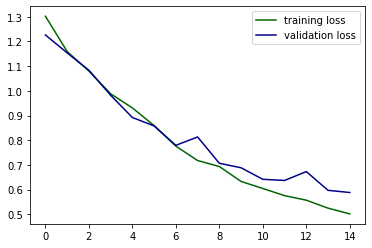

(<keras.engine.sequential.Sequential at 0x7ff37ac31c90>,
 <keras.callbacks.History at 0x7ff37bcb6c10>)

In [ ]:
# ---+ training and getting visualisations of the GRU
train_plot(model_GRU)

In [ ]:
# ---+ evaluating the model
score, acc= model_GRU.evaluate(X_valid, y_q1_valid)

print("Validation score:", score)
print("validation accuracy:", acc)

19/19 [==============================] - 6s 298ms/step - loss: 0.5882 - Accuracy: 0.7650
Validation score: 0.5881556272506714
validation accuracy: 0.7649999856948853


#### Running GRU with more convolutional layers (optimising the model because of better performance)
#### Convulational layers are used to extract features from the input data. By applying different parameters to the convolutional layers, we can get better results. Such as kernel size, strides, padding, filters, etc.

In [ ]:
# ---+ cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

In [ ]:
# ---+ building the GRU improved model
model_GRU_improved = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 2]),
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 2]),
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 2]),
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 2]),
    GRU(20, return_sequences=True),
    GRU(20),
    Dense(4, activation = "softmax")
])
model_GRU_improved.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          180       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 20)          1620      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 20)          1620      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 20)          1620      
                                                                 
 gru (GRU)                   (None, None, 20)          2520      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense (Dense)               (None, 4)                 8

Epoch 1/15
88/88 [==============================] - 35s 347ms/step - loss: 1.3266 - Accuracy: 0.3668 - val_loss: 1.1702 - val_Accuracy: 0.5167
Epoch 2/15
88/88 [==============================] - 29s 332ms/step - loss: 1.0141 - Accuracy: 0.5643 - val_loss: 0.8921 - val_Accuracy: 0.6000
Epoch 3/15
88/88 [==============================] - 29s 330ms/step - loss: 0.8203 - Accuracy: 0.6700 - val_loss: 0.7477 - val_Accuracy: 0.6867
Epoch 4/15
88/88 [==============================] - 29s 333ms/step - loss: 0.6377 - Accuracy: 0.7546 - val_loss: 0.5885 - val_Accuracy: 0.7717
Epoch 5/15
88/88 [==============================] - 29s 332ms/step - loss: 0.5514 - Accuracy: 0.7889 - val_loss: 0.6148 - val_Accuracy: 0.7550
Epoch 6/15
88/88 [==============================] - 29s 332ms/step - loss: 0.4980 - Accuracy: 0.8118 - val_loss: 0.4365 - val_Accuracy: 0.8433
Epoch 7/15
88/88 [==============================] - 29s 333ms/step - loss: 0.4005 - Accuracy: 0.8496 - val_loss: 0.3786 - val_Accuracy: 0.8533

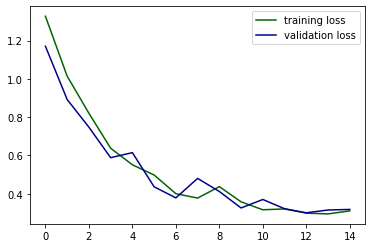

(<keras.engine.sequential.Sequential at 0x7ff37c75e0d0>,
 <keras.callbacks.History at 0x7ff37c601f90>)

In [ ]:
# ---+ training and getting visualisations of the GRU improved model
train_plot(model_GRU_improved)

In [ ]:
# ---+ evaluating the model
score, acc= model_GRU_improved.evaluate(X_valid, y_q1_valid)

print("Validation score:", score)
print("validation accuracy:", acc)

19/19 [==============================] - 1s 61ms/step - loss: 0.3183 - Accuracy: 0.8750
Validation score: 0.3183118402957916
validation accuracy: 0.875


In [ ]:
# ---+ confusion matrix
cm_GRU_improved = confusion_matrix(y_q1_valid, np.asarray(model_GRU_improved.predict(X_valid)).argmax(axis=1))

cm_GRU_improved

array([[103,   1,   3,  47],
       [  1, 136,   3,   1],
       [  7,   2, 142,   1],
       [  2,   6,   1, 144]])

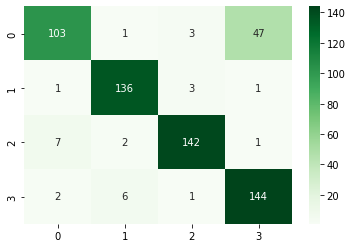

In [ ]:
# ---+ plotting confusion matrix
ax = sns.heatmap(cm_GRU_improved, annot=True, cmap="Greens", fmt="g")

#### Different optimizers applying again for the GRU model, like number of units in the GRU layers.

In [ ]:
# ---+ cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

In [ ]:
# ---+ building the model
model_GRU_different = Sequential([
    Conv1D(filters=20, kernel_size=10, strides=2, padding="valid", input_shape=[None, 2]),
    Conv1D(filters=20, kernel_size=10, strides=2, padding="valid", input_shape=[None, 2]),
    GRU(128, return_sequences=True), # ---+ 128 units each layers, Dense last layer for prediction, sequence elements are of dimension 1
    GRU(128, return_sequences=True),
    GRU(128),
    Dense(4, activation = "softmax")
])
model_GRU_different.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          420       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 20)          4020      
                                                                 
 gru (GRU)                   (None, None, 128)         57600     
                                                                 
 gru_1 (GRU)                 (None, None, 128)         99072     
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 260,700
Trainable params: 260,700
Non-trai

Epoch 1/15
88/88 [==============================] - 373s 4s/step - loss: 1.2030 - Accuracy: 0.4479 - val_loss: 1.0653 - val_Accuracy: 0.5600
Epoch 2/15
88/88 [==============================] - 363s 4s/step - loss: 0.7137 - Accuracy: 0.7196 - val_loss: 0.5325 - val_Accuracy: 0.7750
Epoch 3/15
88/88 [==============================] - 362s 4s/step - loss: 0.4622 - Accuracy: 0.8161 - val_loss: 0.5414 - val_Accuracy: 0.7717
Epoch 4/15
88/88 [==============================] - 362s 4s/step - loss: 0.3450 - Accuracy: 0.8668 - val_loss: 0.4751 - val_Accuracy: 0.8017
Epoch 5/15
88/88 [==============================] - 363s 4s/step - loss: 0.2957 - Accuracy: 0.8761 - val_loss: 0.3368 - val_Accuracy: 0.8750
Epoch 6/15
88/88 [==============================] - 422s 5s/step - loss: 0.2541 - Accuracy: 0.8932 - val_loss: 0.3163 - val_Accuracy: 0.8783
Epoch 7/15
88/88 [==============================] - 366s 4s/step - loss: 0.2274 - Accuracy: 0.9021 - val_loss: 0.3077 - val_Accuracy: 0.8833
Epoch 8/15
88

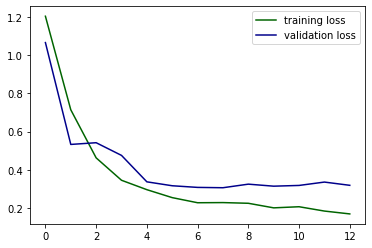

(<keras.engine.sequential.Sequential at 0x7ff37d1ef810>,
 <keras.callbacks.History at 0x7ff37c714190>)

In [ ]:
# ---+ training and getting visualisations of the GRU different approach model
train_plot(model_GRU_different)

In [ ]:
# ---+ evaluating the model
score, acc= model_GRU_different.evaluate(X_valid, y_q1_valid)

print("Validation score:", score)
print("validation accuracy:", acc)

19/19 [==============================] - 15s 788ms/step - loss: 0.3060 - Accuracy: 0.8883
Validation score: 0.30596116185188293
validation accuracy: 0.8883333206176758


# Question 2

## In your own words, explain why the approach outlined here can help analyze time-series data and why it might outperform RNNs.

#### The main difference between CNN and RNN is the way to process temporal information in the input data. CNN can process temporal information in the input data, whereas RNN can only process the information in the sequence.
#### As a result, CNNs and RNNs are used for completely different tasks. CNNs are mostly used for image processing (spatial data), whereas RNNs are usually used for text processing. 
#### CNNs are also more efficient than RNNs. CNNs are more efficient in terms of memory usage, and the number of parameters in the model.
#### Moreover, in terms of training time, they are considered more powerful and faster as they are using more filters, and layers in the model.

#### In this case, the goal is to achieve an approach to diagnose small anomalies in the output of the wind turbine system.
#### The challenges addressed in this paper are dealing with time-series data, and these data are not easily processed by RNNs. 
#### Challenges include: 


*   the tricky nature of the time series, because of how  volatile the data is (e.g. the data is not always increasing/decreasing)
*   the lack of a clear pattern in the data 
*   environmental disturbances

#### One way to deal with time-series is to convert them into 2-D images. It is worth to mention that in CNN approaches, the information is extracted from the image,
#### i.e. the information is extracted from the image by analysing the relationship between the adjacent pixels.
#### Furtermore, another significant difference between CNN and RNN is that the first one is computationally cheaper than RNNs. CNNs learn by batch while RNNs train sequentially.
#### Hence, unlike RNNs, CNNs learn patterns within the time window. 

#### Therefore, the CNN will outperfom RNN in terms of training time, the accuracy, and the sensitivity of the data.

# Question 3

#### Convert the data for use with a CNN. In particular, following the approach outlined in Scenario 2 (section 5.3 of the paper) and summarized in Figure 18, 
#### convert the two time series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a gray- scale image).

In [ ]:
# ---+ creating the input_shape of the model
input_shape = (100, 100, 1)

In [ ]:
# ---+ combining the 2 time series
final_q3 = [np.hstack((time_series_1[i].reshape(100, 50), time_series_2[i].reshape(100, 50))).reshape(100, 100, 1) for i in range(len(time_series_1))]

In [ ]:
# ---+ converting into array
final_q3 = np.array(final_q3)

In [ ]:
# ---+ looking into the shape of the data
print(final_q3.shape)
print(type(final_q3))

(4000, 100, 100, 1)
<class 'numpy.ndarray'>


In [ ]:
# ---+ reshaping y into the shape of the time_series
y_q3 = y
print(y_q3.shape)
print(type(y_q3))

(4000,)
<class 'numpy.ndarray'>


In [ ]:
# ---+ creating training and test split
np.random.seed(132)
seq_steps = 10000

X_q3_train, y_q3_train = final_q3[:2800, :seq_steps], y_q3[:2800,]
X_q3_valid, y_q3_valid = final_q3[2800:3400, :seq_steps], y_q3[2800:3400,]
X_q3_test, y_q3_test = final_q3[3400:, :seq_steps], y_q3[3400:,]

print(X_q3_train.shape)
print(y_q3_train.shape)
print(X_q3_valid.shape)
print(y_q3_test.shape)
print(y_q3_valid.shape)

(2800, 100, 100, 1)
(2800,)
(600, 100, 100, 1)
(600,)
(600,)


In [ ]:
# ---+ transforming the data into floats
X_q3_train = X_q3_train.astype('float32')
X_q3_test = X_q3_test.astype('float32')
X_q3_valid = X_q3_valid.astype('float32')

In [ ]:
# ---+ transforming the data into a range of 0 to 1
num_classes = len(np.unique(y_q3)) # ---+ number of classes in the data

# ---+ convert class vectors to one-hot encoding
y_q3_train = tf.keras.utils.to_categorical(y_q3_train, num_classes)
y_q3_test = tf.keras.utils.to_categorical(y_q3_test, num_classes)
y_q3_valid =  tf.keras.utils.to_categorical(y_q3_valid, num_classes)

In [ ]:
# ---+ printing out the shape of the train splits
print('X_q3_train shape:', X_q3_train.shape)
print('y_q3_train shape:', y_q3_train.shape)
print('X_q3_test shape:', X_q3_test.shape)
print('y_q3_test shape:', y_q3_test.shape)
print('X_q3_valid shape:', X_q3_valid.shape)
print('y_q3_valid shape:', y_q3_valid.shape)

X_q3_train shape: (2800, 100, 100, 1)
y_q3_train shape: (2800, 4)
X_q3_test shape: (600, 100, 100, 1)
y_q3_test shape: (600, 4)
X_q3_valid shape: (600, 100, 100, 1)
y_q3_valid shape: (600, 4)


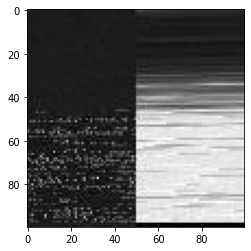

In [ ]:
# ---+ visualising the data
plt.imshow(X_q3_train[1,:,:,0], cmap = 'gray')
plt.show()

# Question 4

#### In TensorFlow, replicate the CNN with two convolutional layers displayed in Figure 12 and train it on your data. Make sure to record your final validation set accuracy.

## Building a CNN for our data

#### Convulotional neural network(CNN) is a type of deep learning model for processing data that has a grid pattern, such as images.
#### The network of the CNNs leans to optimize the filters(kernerls) through automated learning, whereas in traditional deep learning models, the filters are manually tuned.
#### A CNN has three layers: a convolutional layer, a pooling layer and a fully connected layer.

#### Convulotional layer: convolve the input and pass its result to the next layer.
#### Pooling layer: reduce the size of the input by taking the maximum value of the input.
#### Fully connected layer: connect the pooling layer to the output layer.

In [ ]:
# ---+ cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

In [ ]:
# ---+ building the model for the CNN
model_CNN = Sequential([
    Conv2D(32, kernel_size=(3, 3), input_shape = input_shape),
    Conv2D(32, kernel_size=(3, 3)),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3), activation = "relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')])

model_CNN.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 96, 96, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 15376)             0         
                                                        

In [ ]:
# ---+ training and getting visualisations of the CNN model
log_CNN = model_CNN.fit(X_q3_train, y_q3_train,
          epochs = 15, validation_data = (X_q3_valid, y_q3_valid))

Epoch 1/15
88/88 [==============================] - 110s 1s/step - loss: 1.2092 - accuracy: 0.4514 - val_loss: 0.9192 - val_accuracy: 0.6367
Epoch 2/15
88/88 [==============================] - 105s 1s/step - loss: 0.6127 - accuracy: 0.7629 - val_loss: 0.3838 - val_accuracy: 0.8017
Epoch 3/15
88/88 [==============================] - 105s 1s/step - loss: 0.3410 - accuracy: 0.8696 - val_loss: 0.2653 - val_accuracy: 0.8950
Epoch 4/15
88/88 [==============================] - 105s 1s/step - loss: 0.3094 - accuracy: 0.8818 - val_loss: 0.2996 - val_accuracy: 0.9017
Epoch 5/15
88/88 [==============================] - 105s 1s/step - loss: 0.2952 - accuracy: 0.8807 - val_loss: 0.2663 - val_accuracy: 0.8900
Epoch 6/15
88/88 [==============================] - 105s 1s/step - loss: 0.2672 - accuracy: 0.8807 - val_loss: 0.2604 - val_accuracy: 0.8983
Epoch 7/15
88/88 [==============================] - 105s 1s/step - loss: 0.2861 - accuracy: 0.8821 - val_loss: 0.2501 - val_accuracy: 0.9033
Epoch 8/15
88

In [ ]:
# ---+ evaluating the model
score, acc= model_CNN.evaluate(X_q3_valid, y_q3_valid)

print("Validation score:", score)
print("validation accuracy:", acc)

19/19 [==============================] - 4s 223ms/step - loss: 0.2497 - accuracy: 0.8967
Validation score: 0.2496543675661087
validation accuracy: 0.8966666460037231


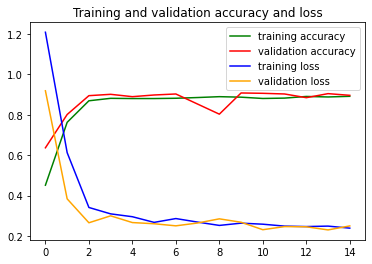

In [ ]:
# ---+ visualising the model
def create_plot(log):
    plt.plot(log.history['accuracy'], label = 'training accuracy', color = 'green')
    plt.plot(log.history['val_accuracy'], label = 'validation accuracy', color = 'red')
    plt.plot(log.history['loss'], label = 'training loss', color = 'blue')
    plt.plot(log.history['val_loss'], label = 'validation loss', color = 'orange')
    plt.title('Training and validation accuracy and loss')
    plt.legend()
    plt.show()
create_plot(log_CNN)

In [ ]:
# ---+ confusion matrix
cm_Q4 = confusion_matrix(y_q1_valid, np.asarray(model_CNN.predict(X_q3_valid)).argmax(axis=1))

cm_Q4

array([[110,   0,   0,  44],
       [  2, 139,   0,   0],
       [  2,   1, 149,   0],
       [ 11,   0,   2, 140]])

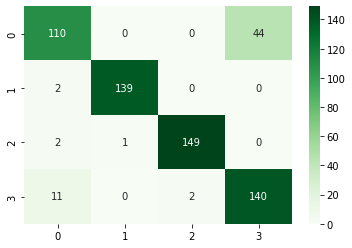

In [ ]:
# ---+ plotting confusion matrix
ax = sns.heatmap(cm_Q4, annot=True, cmap="Greens", fmt="g")

# Question 5

#### Can you do better by adjusting the CNN? Be creative in your design choices (you might also consider pre-trained CNN architectures) and record your final validation set accuracy.

In [ ]:
# ---+ cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

#### Use of a new callback, the 'ReduceLROnPlateau, which observes a certain metric and if this metric no longer improves (considering a certain patience), reduces the learning rate by a given factor.

#### Very similar to the learning rate schedules, only some different mechanisms.

In [ ]:
# ---+ adding a callback to the model
lr_red_callback = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, verbose = 1, factor = 0.3, min_lr = 1e-6)

#### Building AlexNet model

In [ ]:
# ---+ building the AlexNet model for the CNN
model_AlexNet = Sequential([
    Conv2D(96, 11, strides = 4, padding = 'same', activation = 'relu', input_shape = input_shape),
    BatchNormalization(),
    MaxPooling2D(3, strides=2),
    Conv2D(256, 5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(3, strides=2),
    Conv2D(384, 3, strides=1, padding='same', activation='relu'),
    Conv2D(384, 3, strides=1, padding='same', activation='relu'),
    Conv2D(256, 3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(3, strides=2),
    Flatten(),
    Dense(4096, activation = 'relu'),
    Dense(4096, activation = 'relu'),
    Dense(num_classes, activation = 'softmax')])

model_AlexNet.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])
model_AlexNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 25, 25, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
# ---+ training and getting visualisations of the CNN model
log_AlexNet = model_AlexNet.fit(X_q3_train, y_q3_train,
          epochs = 15, callbacks = lr_red_callback, validation_data = (X_q3_valid, y_q3_valid))

Epoch 1/15
88/88 [==============================] - 106s 1s/step - loss: 1.8810 - accuracy: 0.5314 - val_loss: 3.5884 - val_accuracy: 0.2533 - lr: 0.0010
Epoch 2/15
88/88 [==============================] - 105s 1s/step - loss: 0.5393 - accuracy: 0.7689 - val_loss: 3.6335 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 3/15
88/88 [==============================] - 106s 1s/step - loss: 0.3242 - accuracy: 0.8689 - val_loss: 1.3543 - val_accuracy: 0.4833 - lr: 0.0010
Epoch 4/15
88/88 [==============================] - 106s 1s/step - loss: 0.2802 - accuracy: 0.8786 - val_loss: 0.3444 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 5/15
88/88 [==============================] - 106s 1s/step - loss: 0.7530 - accuracy: 0.6954 - val_loss: 1.3177 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 6/15
88/88 [==============================] - ETA: 0s - loss: 0.3550 - accuracy: 0.8504
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
88/88 [==============================] - 106s 1s/step - loss

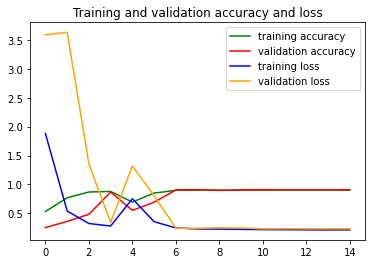

In [ ]:
# ---+ visualising the model
def create_plot(log):
    plt.plot(log.history['accuracy'], label = 'training accuracy', color = 'green')
    plt.plot(log.history['val_accuracy'], label = 'validation accuracy', color = 'red')
    plt.plot(log.history['loss'], label = 'training loss', color = 'blue')
    plt.plot(log.history['val_loss'], label = 'validation loss', color = 'orange')
    plt.title('Training and validation accuracy and loss')
    plt.legend()
    plt.show()
create_plot(log_AlexNet)

In [ ]:
# ---+ confusion matrix
cm_AlexNet = confusion_matrix(y_q1_valid, np.asarray(model_AlexNet.predict(X_q3_valid)).argmax(axis=1))

cm_AlexNet

array([[107,   0,   0,  47],
       [  2, 139,   0,   0],
       [  2,   1, 149,   0],
       [  2,   0,   2, 149]])

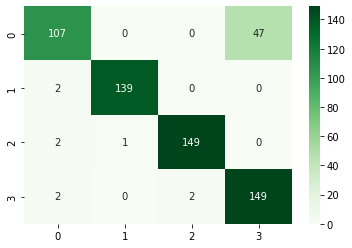

In [ ]:
# ---+ plotting confusion matrix
ax = sns.heatmap(cm_AlexNet, annot=True, cmap="Greens", fmt="g")

#### Implementing MobileNet Architecture

In [ ]:
# ---+ transforming the data into the shape for mobilenet
X_q3_train = tf.constant(X_q3_train)
X_q3_valid = tf.constant(X_q3_valid)

# ---+ converting 1 channel into 3 channel image

X_q3_train_image = tf.image.grayscale_to_rgb(X_q3_train)
X_q3_valid_image = tf.image.grayscale_to_rgb(X_q3_valid)

In [ ]:
# ---+ printing the shape of the preprocessed data
x_preprocess_train = preprocess_input(X_q3_train_image)
x_preprocess_valid = preprocess_input(X_q3_valid_image)
x_preprocess_train.shape, x_preprocess_valid.shape

(TensorShape([2800, 100, 100, 3]), TensorShape([600, 100, 100, 3]))

In [ ]:
# ---+ mobilenet with frozen layers
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape = (100, 100, 3))
mobilenet.trainable = False

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# ---+ building MobileNet model
model_MobileNet = Sequential([
    UpSampling2D(size=(1, 1), input_shape = (100, 100, 3)),
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')])
    
model_MobileNet.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_MobileNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 100, 100, 3)      0         
 )                                                               
                                                                 
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 64)                65600     
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                      

In [ ]:
# add these to the final script
log_MobileNet = model_MobileNet.fit(x_preprocess_train, y_q3_train,
          batch_size=32,
          epochs=15, callbacks = lr_red_callback,validation_data = (x_preprocess_valid, y_q3_valid))

Epoch 1/15
88/88 [==============================] - 26s 271ms/step - loss: 1.1962 - accuracy: 0.5146 - val_loss: 1.0037 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 2/15
88/88 [==============================] - 23s 265ms/step - loss: 0.8847 - accuracy: 0.6850 - val_loss: 0.7844 - val_accuracy: 0.7267 - lr: 0.0010
Epoch 3/15
88/88 [==============================] - 23s 265ms/step - loss: 0.7632 - accuracy: 0.7254 - val_loss: 0.6910 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 4/15
88/88 [==============================] - 23s 266ms/step - loss: 0.6414 - accuracy: 0.7818 - val_loss: 0.6074 - val_accuracy: 0.8117 - lr: 0.0010
Epoch 5/15
88/88 [==============================] - 23s 267ms/step - loss: 0.5806 - accuracy: 0.7986 - val_loss: 0.5216 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 6/15
88/88 [==============================] - 23s 266ms/step - loss: 0.5034 - accuracy: 0.8361 - val_loss: 0.4831 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 7/15
88/88 [==============================] - 23s 267ms/st

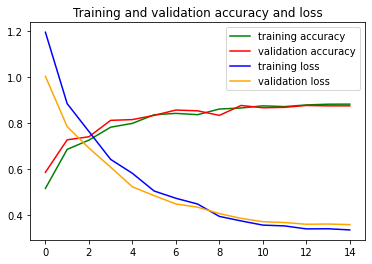

In [ ]:
# ---+ visualising the results
create_plot(log_MobileNet)

In [ ]:
# ---+ confusion matrix
cm_MobileNet = confusion_matrix(y_q1_valid, np.asarray(model_MobileNet.predict(x_preprocess_valid)).argmax(axis=1))

cm_MobileNet

array([[109,   0,   5,  40],
       [  2, 135,   2,   2],
       [  1,   1, 147,   3],
       [ 17,   0,   2, 134]])

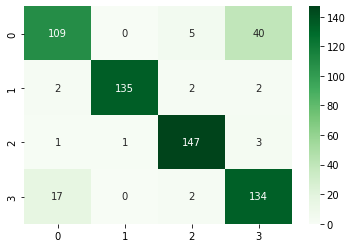

In [ ]:
# ---+ plotting confusion matrix
ax = sns.heatmap(cm_MobileNet, annot=True, cmap="Greens", fmt="g")

#### Improvement of the papper's model by adjusting and adding extra parameters, like padding, strides, normalizaton,and multiple convolutional layers.

In [ ]:
# ---+ cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

In [ ]:
# ---+ building the imporved model for the CNN (Q4)
model_CNN_updated = Sequential([
    Conv2D(32, 11, strides = 4, padding = 'same', activation = 'relu', input_shape = input_shape),
    BatchNormalization(),
    Conv2D(32, 5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(3, strides=2),
    Conv2D(96, kernel_size=(3, 3), padding = 'same'),
    Conv2D(96, kernel_size=(3, 3)),
    Dropout(0.2),
    Conv2D(256, kernel_size=(3, 3), activation = "relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')])

model_CNN_updated.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])
model_CNN_updated.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 25, 25, 32)        3904      
                                                                 
 batch_normalization_6 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_16 (Conv2D)          (None, 25, 25, 32)        25632     
                                                                 
 batch_normalization_7 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                      

In [ ]:
# ---+ training and getting visualisations of the CNN model
log_CNN_updated = model_CNN_updated.fit(X_q3_train, y_q3_train,
          epochs = 15, callbacks = lr_red_callback, validation_data = (X_q3_valid, y_q3_valid))

Epoch 1/15
88/88 [==============================] - 32s 362ms/step - loss: 0.2467 - accuracy: 0.8914 - val_loss: 0.3035 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 2/15
88/88 [==============================] - 28s 318ms/step - loss: 0.2345 - accuracy: 0.9004 - val_loss: 0.3144 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 3/15
88/88 [==============================] - ETA: 0s - loss: 0.2339 - accuracy: 0.8964
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
88/88 [==============================] - 28s 319ms/step - loss: 0.2339 - accuracy: 0.8964 - val_loss: 0.2849 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 4/15
88/88 [==============================] - 29s 324ms/step - loss: 0.2167 - accuracy: 0.9032 - val_loss: 0.2276 - val_accuracy: 0.9067 - lr: 3.0000e-04
Epoch 5/15
88/88 [==============================] - 28s 318ms/step - loss: 0.2122 - accuracy: 0.9029 - val_loss: 0.2490 - val_accuracy: 0.9067 - lr: 3.0000e-04
Epoch 6/15
88/88 [==============================] - E

In [ ]:
# ---+ evaluating the model
score, acc= model_CNN_updated.evaluate(X_q3_valid, y_q3_valid)

print("Validation score:", score)
print("validation accuracy:", acc)

19/19 [==============================] - 1s 72ms/step - loss: 0.2360 - accuracy: 0.9067
Validation score: 0.23603080213069916
validation accuracy: 0.9066666960716248


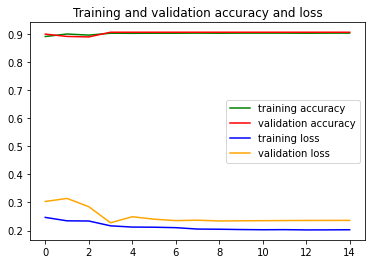

In [ ]:
# ---+ visualising the results
create_plot(log_CNN_updated)

In [ ]:
# ---+ confusion matrix
cm_Q4_updated = confusion_matrix(y_q1_valid, np.asarray(model_CNN_updated.predict(X_q3_valid)).argmax(axis=1))

cm_Q4_updated

array([[107,   0,   0,  47],
       [  2, 139,   0,   0],
       [  2,   1, 149,   0],
       [  2,   0,   2, 149]])

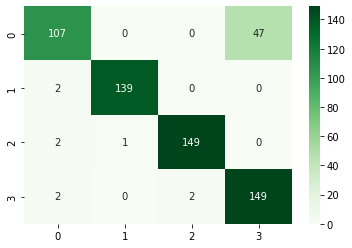

In [ ]:
# ---+ plotting confusion matrix
ax = sns.heatmap(cm_Q4_updated, annot=True, cmap="Greens", fmt="g")

# Question 6

#### Compare the models you have created so far (both RNNs and CNNs) and make a selection (making sure to justify this). Train that model on a combined training and validation set and evaluate it on your test set.

#### By comparing the models we have created so far, we can see that the CNN model is better than the RNN model.


#### The CNN model is better because it has a more complex architecture and it is able to learn more complex patterns.


#### By training the CNN model on the combined training and validation set, we can see that the accuracy of the CNN model is higher than the accuracy of the RNN model.


#### Lastly, we will choose the best CNN model and train it on the combined training and validation set, and evaluate it on the test set.

##### Let's have a look on the compred models for our conclusion:


| Type of CNN models      | Models      | Accuracy      |
| :---        |    :----:   |          ---: |
| CNN basic model      | Paper's CNN | 89.18%  |
| Transfer learning model  | AlexNet        | 90.29%   |
| Transfer learning model      | MobileNet | 88.25%  |
| Paper's improved version   | Improving paper's CNN        | 90.36%     |

#### It is shown that all models scored a really high accuracy. 

#### The paper's model, with only 3 convolutional layers, a dropout, a maxpooling(suitable spatial data), one flatten layer, and a Dense layer with an activation function 'softmax', scored an accuracy of 89.18% which is significantly impressive.

#### The next model was the AlexNet. This model used multiple convolutional layers, with dropouts and maxpooling, as long as with the use of 'BatchNormalization' which standardizes the inputs to a layer for each mini-batch. More parameters were used to optimize the model like padding, strides, filters, and more activations for every layer.

#### As already mentioned with AlexNet, MobileNet is a model of the same category as the first one. In order to implement the MobileNet architecture a preprocess of the data was followed. The data were transformed from 1 channel to 3 channel i.e converted the gray images into RGB ones. Moreover, upsampling layer was used (scaling up for the image), global average pooling, and some frozen layers in order to optimize the paper's model.

#### Lastly, the improvement of the paper's model was tried to be optimized. Extra layers, filters, kernel size, padding, strides and activations were added to different layers. Dropouts were used to make the model more accurate, as long as BatchNormalization, however a high accuracy scored was noted but not with a big difference from the original one.

#### The analysis was followed by implementing multiple models. The mentioned ones were the most suitable ones. Different approaches regarding the evaluation and training of the models were GoogleNet which showed significant overfiting after some time of training and Inception (both categorized as transfer learning models). Moreover, even the augmentation of the images was considered but the results were dissapointing scoring an accuracy approximately to 25%.


#### Hence, by comparing both RNNs and CNNs, the last ones showed better and higher accuracy scores, and with less computational power. The evaluation of the final model will be on the paper's ones (Q4 model), because even with not too much optimization the accuracy levels, as long as the missclassification of only some points for class 0 (healthy turbine) were quite accurate. 

In [ ]:
# ---+ cleaning the session

tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(658)

In [ ]:
# ---+ building the model for the CNN
model_final = Sequential([
    Conv2D(32, kernel_size=(3, 3), input_shape = input_shape),
    Conv2D(32, kernel_size=(3, 3)),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3), activation = "relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')])

model_final.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])
model_final.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 96, 96, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 15376)             0         
                                                        

In [ ]:
# ---+ training and getting visualisations of the CNN model
log_final = model_final.fit(X_q3_train, y_q3_train,
          epochs = 20)

Epoch 1/20
88/88 [==============================] - 109s 1s/step - loss: 0.2700 - accuracy: 0.8757
Epoch 2/20
88/88 [==============================] - 103s 1s/step - loss: 0.2469 - accuracy: 0.8904
Epoch 3/20
88/88 [==============================] - 104s 1s/step - loss: 0.2429 - accuracy: 0.8879
Epoch 4/20
88/88 [==============================] - 102s 1s/step - loss: 0.2364 - accuracy: 0.8871
Epoch 5/20
88/88 [==============================] - 103s 1s/step - loss: 0.2428 - accuracy: 0.8904
Epoch 6/20
88/88 [==============================] - 103s 1s/step - loss: 0.2407 - accuracy: 0.8932
Epoch 7/20
88/88 [==============================] - 103s 1s/step - loss: 0.2499 - accuracy: 0.8825
Epoch 8/20
88/88 [==============================] - 104s 1s/step - loss: 0.2348 - accuracy: 0.8939
Epoch 9/20
88/88 [==============================] - 105s 1s/step - loss: 0.2354 - accuracy: 0.8911
Epoch 10/20
88/88 [==============================] - 104s 1s/step - loss: 0.2364 - accuracy: 0.8950
Epoch 11/

In [ ]:
# ---+ saving the file into h5-file
model_final.save('/content/sample_data/final-model.h5')

In [ ]:
# ---+ evaluating the model
score, acc= model_final.evaluate(X_q3_test, y_q3_test)

print("Validation score:", score)
print("validation accuracy:", acc)

19/19 [==============================] - 4s 226ms/step - loss: 0.3073 - accuracy: 0.8800
Validation score: 0.3073076605796814
validation accuracy: 0.8799999952316284


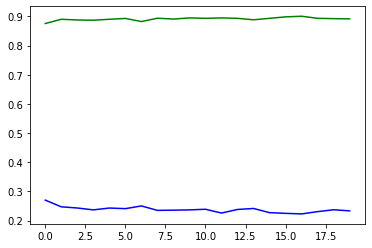

In [ ]:
# ---+ visualising the model
plt.plot(log_final.history['accuracy'], label = 'training accuracy', color = 'green')
plt.plot(log_final.history['loss'], label = 'training loss', color = 'blue')

In [ ]:
# ---+ confusion matrix
cm_final = confusion_matrix(y_q1_test, np.asarray(model_final.predict(X_q3_test)).argmax(axis=1))

cm_final

array([[101,   0,   0,  55],
       [  5, 140,   0,   0],
       [  3,   3, 139,   0],
       [  2,   0,   4, 148]])

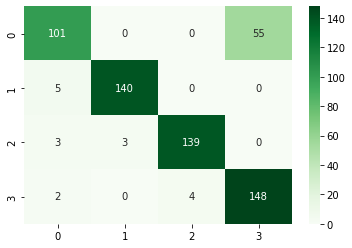

In [ ]:
# ---+ plotting confusion matrix
ax = sns.heatmap(cm_final, annot=True, cmap="Greens", fmt="g")

#### Therefore, after evaluating the model on the test set, the accuracy is up to ~90%. Meaning (as it is observed above) that the number of correct predictions in the whole data set is quite high. It is shown that only for 55 of class 0 were missclassified as class 3. This could occur because of the nature of the data. If both of these classes have similar characteristics might be logical that the model missclassified them.

#### In order for the model to be improved, more data could be inlcuded in the predictions (some feautures of this class might not be learned by the computer).Another way for improvement is to pre-process the data before predictions and classifications.